In [1]:
from typing import List
from copy import deepcopy

import random
import collections

import h5py

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator
from qiskit.transpiler.passes import RemoveFinalMeasurements
from qiskit.qasm2 import dumps

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates, project_operator_to_subspace

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [2]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/backends/nighthawk/fake_nighthawk.py:76: UserWarning: Properties of fake_nighthawk are not intended to represent typical nighthawk error values.
  warnings.warn(


## Build a tiled pool

In [3]:
max_mpo_bond = 300
dmrg_mps_bond = 30
adapt_mps_bond = 30
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [211]
Gradients: [np.float64(4.000000000000012)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [211]...
Starting point: [np.float64(0.0)]

Current energy: -3.828427124746197
(change of -0.8284271247461925)
Current ansatz: [211]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.78207252017211
Operator(s) added to ansatz: [241]
Gradients: [np.float64(3.4142135623691776)]
Initial energy: -3.828427124746197
Optimizing energy with indices [211, 241]...
Starting point: [np.float64(-0.3926990817001106), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -4.626284539634973
(change of -0.7978574148887763)
Current ansatz: [211, 241]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 12.26780273456531
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-3.7252880142064084)]
Initial energy: -4.626284539634973
Optimizing energy with indices [211, 241, 79]...
Starting point: [np.float64(-0.2651612342265216), np.float64(-0.44546905390000224), np.float64(0.0)]

Current energy: -6.123105625614734
(change of -1.4968210859797608)
Current ansatz: [211, 241, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917530720141803
Operator(s) added to ansatz: [141]
Gradients: [np.float64(2.4850735669967787)]
Initial energy: -6.123105625614734
Optimizing energy with indices [211, 241, 79, 141]...
Starting point: [np.float64(-0.122489928621197), np.float64(-0.7853981633782835), np.float64(0.7

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 198]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072706
(change of -0.13682546025271858)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013508605500525537

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 74]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.3272761548199865
(change of -0.20417052920233925)
Current ansatz: [244, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042725676
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916426871504)]
Initial energy: -6.3272761548199865
Optimizing energy with indices [244, 74, 228, 210, 147]...
Starting point: [np.float64(0.7853981633887943), np.float64(-0.7853981634091799), np.float64(0.1635702865670706), np.float64(0.16356997225170858), np.float64(0.0)]

Current energy: -6.464101615072783
(change of -0.13682546025279674)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474288453)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 198]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819708
(change of -0.2041705292020657)
Current ansatz: [241, 79, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531757
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.089492926734933)]
Initial energy: -6.327276154819708
Optimizing energy with indices [241, 79, 228, 198, 135]...
Starting point: [np.float64(-0.7853981618473267), np.float64(0.7853981651745618), np.float64(0.16357019740836948), np.float64(-0.16356963668286137), np.float64(0.0)]

Current energy: -6.464101615134325
(change of -0.1368254603146175)
Current ansatz: [241, 79, 228, 198, 135]
Performing final convergence check...
Total gradient norm: 2.9260788111326973e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531757 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating li

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200048677
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477671423)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 210]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.12248927943049101), np.float64(0.0)]

Current energy: -6.3272761548197005
(change of -0.20417052920205325)
Current ansatz: [244, 74, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096258053184
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894929267348776)]
Initial energy: -6.3272761548197005
Optimizing energy with indices [244, 74, 225, 210, 198]...
Starting point: [np.float64(0.7853981634001291), np.float64(-0.785398163399394), np.float64(-0.16357019740837944), np.float64(0.16356963668287733), np.float64(0.0)]

Current energy: -6.464101615135405
(change of -0.13682546031570464)
Current

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]

Current energy: -6.327276154819982
(change of -0.20417052920234013)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138082
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916438682523)]
Initial energy: -6.327276154819982
Optimizing energy with indices [241, 79, 228, 210, 198]...
Starting point: [np.float64(-0.7853982024976439), np.float64(0.7853981311150512), np.float64(0.1635702864850446), np.float64(0.16356997194303877), np.float64(0.0)]

Current energy: -6.4641016145547825
(change of -0.13682545973480043)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00033002067862662824

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 74]...
Starting point: [np.float64(0.5535743588970456), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.3272761548199865
(change of -0.20417052920233925)
Current ansatz: [244, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042725676
Operator(s) added to ansatz: [57]
Gradients: [np.float64(2.0894916426871504)]
Initial energy: -6.3272761548199865
Optimizing energy with indices [244, 74, 228, 210, 57]...
Starting point: [np.float64(0.7853981633887943), np.float64(-0.7853981634091799), np.float64(0.1635702865670706), np.float64(0.16356997225170858), np.float64(0.0)]

Current energy: -6.464101615072802
(change of -0.1368254602528154)
Current ansa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752619944251
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429297)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 79, 225, 210]...
Starting point: [np.float64(-0.7853981627578538), np.float64(0.78539816425353), np.float64(-0.12248927934343061), np.float64(0.0)]

Current energy: -6.327276154819705
(change of -0.2041705292020577)
Current ansatz: [241, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531791
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894929267348776)]
Initial energy: -6.327276154819705
Optimizing energy with indices [241, 79, 225, 210, 147]...
Starting point: [np.float64(-0.7853981607743267), np.float64(0.7853981678304174), np.float64(-0.163570197408367), np.float64(0.16356963668287403), np.float64(0.0)]

Current energy: -6.464101615008459
(change of -0.13682546018875374)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971140567
Operator(s) added to ansatz: [225]
Gradients: [np.float64(1.99999999999442)]
Initial energy: -5.999999999998185
Optimizing energy with indices [228, 74, 225]...
Starting point: [np.float64(-0.7853985607314252), np.float64(-0.7853989420959435), np.float64(0.0)]

Current energy: -6.123105625610642
(change of -0.12310562561245764)
Current ansatz: [228, 74, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955728
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485068789868942)]
Initial energy: -6.123105625610642
Optimizing energy with indices [228, 74, 225, 210]...
Starting point: [np.float64(-0.7853983869831797), np.float64(-0.7853991695302367), np.float64(-0.12248869758310571), np.float64(0.0)]

Current energy: -6.327276154816355
(change of -0.20417052920571255)
Current ansatz: [228, 74, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.7639320224983894)
Current ansatz: [225, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140572
Operator(s) added to ansatz: [225]
Gradients: [np.float64(1.999999999994421)]
Initial energy: -5.999999999998188
Optimizing energy with indices [225, 79, 225]...
Starting point: [np.float64(0.7853985607314237), np.float64(0.7853989420959421), np.float64(0.0)]

Current energy: -6.123105625610644
(change of -0.12310562561245586)
Current ansatz: [225, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955813
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485068789868988)]
Initial energy: -6.123105625610644
Optimizing energy with indices [225, 79, 225, 210]...
Starting point: [np.float64(0.7853983869831812), np.float64(0.7853991695302517), np.float64(-0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917518430081312
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485066714324805)]
Initial energy: -6.1231056252069065
Optimizing energy with indices [228, 79, 216, 225]...
Starting point: [np.float64(-0.7853879048615375), np.float64(0.7853901599313474), np.float64(-0.12248816317024809), np.float64(0.0)]

Current energy: -6.327276154818593
(change of -0.20417052961168647)
Current ansatz: [228, 79, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964791886525
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.089491649572313)]
Initial energy: -6.327276154818593
Optimizing energy with indices [228, 79, 216, 225, 201]...
Starting point: [np.float64(-0.7853981629684735), np.float64(0.7853982668128193), np.float64(-0.163570458016993), np.float64(-0.16357001840315244), np.float64(0.0)]

Current energy: -6.464101615072778
(change of -0.13682546025418496)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819982
(change of -0.20417052920234013)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138082
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916438682523)]
Initial energy: -6.327276154819982
Optimizing energy with indices [241, 79, 228, 210, 198]...
Starting point: [np.float64(-0.7853982024976439), np.float64(0.7853981311150512), np.float64(0.1635702864850446), np.float64(0.16356997194303877), np.float64(0.0)]

Current energy: -6.4641016145547825
(change of -0.13682545973480043)
Current ansatz: [241, 79, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00033002067862662824

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating lis

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617644
(change of -0.12310562561763749)
Current ansatz: [244, 31, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201327163
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.4850710484797025)]
Initial energy: -6.123105625617644
Optimizing energy with indices [244, 31, 210, 225]...
Starting point: [np.float64(0.7853981648267889), np.float64(-0.785398161917778), np.float64(0.12248927961411428), np.float64(0.0)]

Current energy: -6.327276154819705
(change of -0.20417052920206125)
Current ansatz: [244, 31, 210, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531958
Operator(s) added to ansatz: [99]
Gradients: [np.float64(-2.0894929267348785)]
Initial energy: -6.327276154819705
Optimizing energy with indices [244, 31, 210, 225, 99]...
Starting point: [np.float64(0.7853981627311897

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000004)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 225]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200048677
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.485071047767142)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 147]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 198]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819706
(change of -0.20417052920206658)
Current ansatz: [244, 79, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531788
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089492926734881)]
Initial energy: -6.327276154819706
Optimizing energy with indices [244, 79, 228, 198, 210]...
Starting point: [np.float64(0.7853981646905418), np.float64(0.7853981643651434), np.float64(0.16357019740836648), np.float64(-0.1635696366828733), np.float64(0.0)]

Current energy: -6.464101615132637
(change of -0.13682546031293086)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.0000000000000036)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 216]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [244, 74, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200950523
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.4850710482697833)]
Initial energy: -6.123105625617642
Optimizing energy with indices [244, 74, 216, 225]...
Starting point: [np.float64(0.7853981633664252), np.float64(-0.7853981637522963), np.float64(-0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013624638557904482

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964042797667 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [228]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [228]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499795
(change of -1.2360679774997907)
Current ansatz: [228]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696158
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000003)]
Initial energy: -4.236067977499795
Optimizing energy with indices [228, 74]...
Starting point: [np.float64(-0.5535743588970451), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971140567
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-1.9999999999993707)]
Initial energy: -5.999999999998185
Optimizing energy with indices [228, 74, 201]...
Starting point: [np.float64(-0.7853985607314252), np.float64(-0.7853989420959435), np.float64(0.0)]

Current energy: -6.123105625475225
(change of -0.12310562547704063)
Current ansatz: [228, 74, 201]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526155305602
Operator(s) added to ansatz: [177]
Gradients: [np.float64(-2.485071021855692)]
Initial energy: -6.123105625475225
Optimizing energy with indices [228, 74, 201, 177]...
Starting point: [np.float64(-0.7854038547370663), np.float64(-0.7854037258579853), np.float64(0.12248927291523236), np.float64(0.0)]

Current energy: -6.327276154553898
(change of -0.20417052907867284)
Current ansatz: [228, 74, 201, 177]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240988002134787
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.089491905002376)]
Initial energy: -6.327276154553898
Optimizing energy with indices [228, 74, 201, 177, 216]...
Starting point: [np.float64(-0.7853981579292243), np.float64(-0.7853980639598565), np.float64(0.16357577684185218), np.float64(0.1635714399823413), np.float64(0.0)]

Current energy: -6.464101615031839
(change of -0.13682546047794109)
Current ansatz: [228, 74, 201, 177, 216]
Performing final convergence check...
Total gradient norm: 0.00016117622623940407

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240988002134787 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 198]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.1224892

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199440658
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.4850710474282707)]
Initial energy: -6.123105625617631
Optimizing energy with indices [244, 26, 225, 135]...
Starting point: [np.float64(0.7853981632980831), np.float64(0.78539816328158), np.float64(-0.12248927934316764), np.float64(0.0)]

Current energy: -6.327276154819705
(change of -0.20417052920207368)
Current ansatz: [244, 26, 225, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531781
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894929267348807)]
Initial energy: -6.327276154819705
Optimizing energy with indices [244, 26, 225, 135, 198]...
Starting point: [np.float64(0.7853981624018535), np.float64(0.7853981626466596), np.float64(-0.1635701974083663), np.float64(0.1635696366828732), np.float64(0.0)]

Current energy: -6.4641016151353075
(change of -0.1368254603156025)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 198]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072706
(change of -0.13682546025271858)
Current ansatz: [244, 79, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00013508605500525537

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating lis

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620177583
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071048468285)]
Initial energy: -6.123105625562494
Optimizing energy with indices [228, 79, 225, 210]...
Starting point: [np.float64(-0.7853947065772614), np.float64(0.7853985308794381), np.float64(-0.12248927961669928), np.float64(0.0)]

Current energy: -6.327276154764743
(change of -0.20417052920224865)
Current ansatz: [228, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962581220501
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894929267302738)]
Initial energy: -6.327276154764743
Optimizing energy with indices [228, 79, 225, 210, 198]...
Starting point: [np.float64(-0.7853947065771463), np.float64(0.7853982468607466), np.float64(-0.16357019741059903), np.float64(0.16356963668331825), np.float64(0.0)]

Current energy: -6.464101615080621
(change of -0.13682546031587872)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 228]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [241, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), n

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00033002067862662824

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [211]
Gradients: [np.float64(4.000000000000012)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [211]...
Starting point: [np.float64(0.0)]

Current energy: -3.828427124746197
(change of -0.8284271247461925)
Current ansatz: [211]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.78207252017211
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-3.4142135623691776)]
Initial energy: -3.828427124746197
Optimizing energy with indices [211, 244]...
Starting point: [np.float64(-0.3926990817001106), np.flo

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625614727
(change of -1.49682108597976)
Current ansatz: [211, 244, 31]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917530720521563
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.485073567208433)]
Initial energy: -6.123105625614727
Optimizing energy with indices [211, 244, 31, 201]...
Starting point: [np.float64(-0.12248992867574016), np.float64(0.7853981549207331), np.float64(-0.7853981610270105), np.float64(0.0)]

Current energy: -6.327276154819711
(change of -0.20417052920498424)
Current ansatz: [211, 244, 31, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580955357
Operator(s) added to ansatz: [180]
Gradients: [np.float64(2.0894929267315017)]
Initial energy: -6.327276154819711
Optimizing energy with indices [211, 244, 31, 201, 180]...
Starting point: [np.float64(-0.163570197503926

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 228]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [241, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), n

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00033002084338061577

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 198]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072706
(change of -0.13682546025271858)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013508605500525537

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 74]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000004)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 228]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.3272761548199865
(change of -0.20417052920233925)
Current ansatz: [244, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042725676
Operator(s) added to ansatz: [57]
Gradients: [np.float64(2.0894916426871504)]
Initial energy: -6.3272761548199865
Optimizing energy with indices [244, 74, 228, 210, 57]...
Starting point: [np.float64(0.78539816338879

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998185
(change of -1.7639320224983894)
Current ansatz: [228, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140567
Operator(s) added to ansatz: [216]
Gradients: [np.float64(1.9999999999993716)]
Initial energy: -5.999999999998185
Optimizing energy with indices [228, 74, 216]...
Starting point: [np.float64(-0.7853985607314252), np.float64(-0.7853989420959435), np.float64(0.0)]

Current energy: -6.123105625475232
(change of -0.12310562547704773)
Current ansatz: [228, 74, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526155292668
Operator(s) added to ansatz: [180]
Gradients: [np.float64(2.485071021848481)]
Initial energy: -6.123105625475232
Optimizing energy with indices [228, 74, 216, 180]...
Starting point: [np.float64(-0.7854038547368931), np.float64(-0.7854037258580634), np.float64(-0.12248927291337362), np.float64(0.0)]

Current energy: -6.327276154553893
(change of -0.2041705290786604)
Current ansatz: [228, 74, 216, 180]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240988001979858
Operator(s) added to ansatz: [54]
Gradients: [np.float64(-2.089491904992957)]
Initial energy: -6.327276154553893
Optimizing energy with indices [228, 74, 216, 180, 54]...
Starting point: [np.float64(-0.7853981579296626), np.float64(-0.7853980639717367), np.float64(-0.16357577680490873), np.float64(-0.16357143997430415), np.float64(0.0)]

Current energy: -6.464101615045918
(change of -0.13682546049202493)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752619944251
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474292965)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 79, 225, 147]...
Starting point: [np.float64(-0.7853981627578538), np.float64(0.78539816425353), np.float64(-0.12248927934343061), np.float64(0.0)]

Current energy: -6.327276154819989
(change of -0.2041705292023419)
Current ansatz: [241, 79, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042617831
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.08949164278134)]
Initial energy: -6.327276154819989
Optimizing energy with indices [241, 79, 225, 147, 210]...
Starting point: [np.float64(-0.7853981633974467), np.float64(0.7853981633974486), np.float64(-0.16357028656039646), np.float64(-0.16356997222705624), np.float64(0.0)]

Current energy: -6.464101615072785
(change of -0.13682546025279585)
Current ansa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.3272761548199865
(change of -0.20417052920233925)
Current ansatz: [244, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042725676
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916426871495)]
Initial energy: -6.3272761548199865
Optimizing energy with indices [244, 74, 228, 210, 198]...
Starting point: [np.float64(0.7853981633887943), np.float64(-0.7853981634091799), np.float64(0.1635702865670706), np.float64(0.16356997225170858), np.float64(0.0)]

Current energy: -6.464101615072771
(change of -0.1368254602527843)
Current an

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617651
(change of -0.1231056256176366)
Current ansatz: [244, 26, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200769645
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071048168968)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 26, 216, 225]...
Starting point: [np.float64(0.7853981651172142), np.float64(0.7853981644855549), np.float64(-0.1224892795340391), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920233658)
Current ansatz: [244, 26, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409640432122835
Operator(s) added to ansatz: [99]
Gradients: [np.float64(-2.0894916422607612)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 26, 216, 225, 99]...
Starting point: [np.float64(0.7853981637617629)

## Run ADAPT at larger size to get a sequence of circuits.

In [4]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [5]:
# Now go to the larger size.
new_l = 5 * l
print(f"new_l = {new_l}")
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(20):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    circuit = data.get_circuit(
        tiled_pool, indices=tn_adapt.indices, coefficients=tn_adapt.coefficients,
        include_ref=True
    )
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

new_l = 20
No pre-computed energy for given parameters.
Solving by DMRG with quimb.
Got DMRG energy -3.47299e+01-4.44089e-14j


/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


Tiled pool has 279 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> Candidates per iteration:  1
> Swap-based circuits for LNN connectivity:  False
> Qiskit-transpiler-based circuits for LNN connectivity:  False

Initial energy: -19.00000000000003
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.000000000000006
Operator 1: -3.9999999999999996
Operator 2: 4.000000000000045
Operator 3: -4.000000000000009
Operator 4: 3.99999999999999
Operator 5: -4.000000000000025
Operator 6: 4.000000000000014
Operator 7: -4.00000000000002
Operator 8: 4.000000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -21.295036
         Iterations: 5
         Function evaluations: 46
         Gradient evaluations: 34

Current energy: -21.295035558182168
(change of -1.058967580682367)
Current ansatz: [278, 276]
On iteration 2.

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.000000000000016
Operator 1: -4.000000000000011
Operator 2: 4.000000000000057
Operator 3: -4.000000000000021
Operator 4: 4.0
Operator 5: -4.0000000000000355
Operator 6: 4.000000000000023
Operator 7: -4.0000000000000275
Operator 8: 4.000000000000019
Operator 9: -4.000000000000024
Operator 10: 4.000000000000042
Operator 11: -4.00000000000005
Operator 12: 4.000000000000038
Operator 13: -4.000000000000056
Operator 14: 3.0643399411510766
Operator 15: 8.728660794155019e-08
Operator 16: 1.5786153796605342
Operator 17: 4.000000000000011
Operator 18: -4.000000000000057
Operator 19: 4.000000000000022
Operat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -23.058333
         Iterations: 6
         Function evaluations: 99
         Gradient evaluations: 88

Current energy: -23.058333386736756
(change of -0.9348707038084143)
Current ansatz: [278, 276, 273, 271]
On iteration 4.

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.0000000000000195
Operator 1: -4.000000000000014
Operator 2: 4.00000000000006
Operator 3: -4.000000000000026
Operator 4: 4.000000000000001
Operator 5: -4.000000000000038
Operator 6: 4.000000000000025
Operator 7: -4.000000000000028
Operator 8: 4.000000000000018
Operator 9: -3.264585425219904
Operator 10: -1.1832257519019436e-08
Operator 11: -2.529170798345911
Operator 12: -2.257776694616282e-07
Operator 13: -3.264585373126036
Operator 14: 3.0643400409612997
Operator 16: 1.5786157053787016
Operator 17: 4.000000000000014
Operator 18: -4.00000000000006
Operator 19: 4.000000000000026
Operato

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -24.715188
         Iterations: 6
         Function evaluations: 63
         Gradient evaluations: 52

Current energy: -24.715187636229196
(change of -0.8284271247461845)
Current ansatz: [278, 276, 273, 271, 268, 264]
On iteration 6.

*** ADAPT-VQE Iteration 7 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.000000000000031
Operator 1: -4.0000000000000275
Operator 2: 3.414213562827059
Operator 4: 3.4142135628270127
Operator 5: -4.000000000000045
Operator 6: 3.4142135633753226
Operator 8: 3.4142135633753163
Operator 9: -3.2645854467556843
Operator 11: -2.5291708947585723
Operator 13: -3.264585448002932
Operator 14: 3.064340046534734
Operator 16: 1.5786157183099325
Operator 17: 4.0000000000000275
Operator 18: -3.4142135628270616
Operator 20: -3.4142135628270105
Operator 21: 4.000000000000045
Operator 22: -3.4142135633753226
Operator 24: -3.41421356337532
Operator 25: 3.264585446755

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -25.951256
         Iterations: 16
         Function evaluations: 187
         Gradient evaluations: 172

Current energy: -25.95125561372905
(change of -1.2360679774998538)
Current ansatz: [278, 276, 273, 271, 268, 264, 208]
On iteration 7.

*** ADAPT-VQE Iteration 8 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 2.8944272066797856
Operator 1: -4.000000000000041
Operator 2: 3.414213559796187
Operator 3: 1.0307915257703504e-08
Operator 4: 3.4142135597961394
Operator 5: -4.000000000000053
Operator 6: 3.414213557352668
Operator 7: 2.0081841072084714e-08
Operator 8: 3.4142135573526655
Operator 9: -3.2645854547784756
Operator 10: 1.9146693298810236e-08
Operator 11: -2.5291709150519814
Operator 12: 4.171448056073769e-08
Operator 13: -3.2645854602735564
Operator 14: 3.064340044258488
Operator 16: 1.5786157123466542
Operator 17: 4.000000000000039
Operator 18: -3.4142135597961873
Operator

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -27.026846
         Iterations: 8
         Function evaluations: 49
         Gradient evaluations: 43

Current energy: -27.026845928981032
(change of -1.0755903152519828)
Current ansatz: [278, 276, 273, 271, 268, 264, 208, 127]
On iteration 8.

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 2.8944272249736565
Operator 1: -4.000000000000045
Operator 2: 3.2087802425820895
Operator 3: -8.057775317063524e-08
Operator 4: 2.243291692837121
Operator 6: 2.243291641329437
Operator 7: 8.172465324770267e-08
Operator 8: 3.208780191074365
Operator 9: -3.264585412122476
Operator 10: -8.931413117498404e-08
Operator 11: -2.529170828926518
Operator 12: -7.008714048701794e-08
Operator 13: -3.2645854168040973
Operator 14: 3.0643400559192884
Operator 15: -1.581226205527031e-08
Operator 16: 1.578615750886891
Operator 17: 4.000000000000045
Operator 18: -3.208780242582092
Oper

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -28.390615
         Iterations: 18
         Function evaluations: 120
         Gradient evaluations: 104

Current energy: -28.390614817127158
(change of -1.3637688881461258)
Current ansatz: [278, 276, 273, 271, 268, 264, 208, 127, 123]
On iteration 9.

*** ADAPT-VQE Iteration 10 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.5313034192819073
Operator 2: 0.8987768008299237
Operator 4: 1.3203286167403159
Operator 6: 1.9165748897632615
Operator 8: 3.1403588056035208
Operator 9: -3.2645854433830865
Operator 11: -2.529170890872379
Operator 13: -3.2645854474893574
Operator 14: 3.064340018243124
Operator 15: 3.603536002927399e-08
Operator 16: 1.5786156502837438
Operator 18: -0.8987768008299291
Operator 20: -1.3203286167403125
Operator 22: -1.9165748897632637
Operator 24: -3.1403588056035248
Operator 25: 3.264585443383086
Operator 27: 2.529170890872379
Operator 29: 3.264585447489357
Op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -28.987473
         Iterations: 12
         Function evaluations: 50
         Gradient evaluations: 39

Current energy: -28.987472894327812
(change of -0.596858077200654)
Current ansatz: [278, 276, 273, 271, 268, 264, 208, 127, 123, 259]
On iteration 10.

*** ADAPT-VQE Iteration 11 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.5313033574083013
Operator 1: 3.554504012764439e-07
Operator 2: 0.8987768176288734
Operator 3: -2.8518603030816776e-07
Operator 4: 1.320328794748126
Operator 5: -2.6538060259963725e-07
Operator 6: 1.9165747042727557
Operator 7: 7.813319439489546e-07
Operator 8: 3.1403585583134124
Operator 9: -3.3379495652037043
Operator 11: -2.938047458355597
Operator 12: 2.1826957394126657e-08
Operator 13: -1.1753257090840845
Operator 14: 2.3628825720105695
Operator 15: -4.766927075294802e-08
Operator 16: 1.2885705918922106
Operator 17: -3.5545040098530207e-07
Operator 1

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -29.598284
         Iterations: 15
         Function evaluations: 83
         Gradient evaluations: 71

Current energy: -29.598283698722838
(change of -0.610810804395026)
Current ansatz: [278, 276, 273, 271, 268, 264, 208, 127, 123, 259, 113]
On iteration 11.

*** ADAPT-VQE Iteration 12 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.47173880050556466
Operator 2: 0.795473667947014
Operator 4: 1.1561822015825562
Operator 6: 1.630272830431795
Operator 7: 1.947692841363395e-08
Operator 8: 2.452315992518665
Operator 9: 2.4560608672673893e-08
Operator 10: 1.289951027354332
Operator 11: -3.2745067538058468
Operator 12: 2.3461514831632458e-08
Operator 13: -1.1171138720151474
Operator 14: 2.337709921139582
Operator 15: 1.1560008505995256e-08
Operator 16: 1.2772224181552514
Operator 18: -0.795473667947019
Operator 20: -1.1561822015825514
Operator 22: -1.6302728304317968
Operator 23: -1.9

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -30.294852
         Iterations: 19
         Function evaluations: 66
         Gradient evaluations: 54

Current energy: -30.294852374757596
(change of -0.696568676034758)
Current ansatz: [278, 276, 273, 271, 268, 264, 208, 127, 123, 259, 113, 257]
On iteration 12.

*** ADAPT-VQE Iteration 13 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 0.37859790746734545
Operator 1: -6.708061533535768e-08
Operator 2: 0.6357425905148053
Operator 3: -1.1493047150580057e-07
Operator 4: 0.9114280295180637
Operator 5: 1.2059949957259622e-07
Operator 6: 1.2404774716362172
Operator 7: -1.9476436736657875e-07
Operator 8: 1.7083608461538746
Operator 9: 3.405664830495465e-07
Operator 10: 1.0949795210651558
Operator 11: -0.38151839186666003
Operator 12: 0.9031864097879894
Operator 13: -0.41964632612589603
Operator 14: 1.5509174853568033
Operator 15: 2.3456737008320516e-07
Operator 16: 0.8912353925334818


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -31.861038
         Iterations: 30
         Function evaluations: 154
         Gradient evaluations: 140

Current energy: -31.861037679334686
(change of -0.19894222672311912)
Current ansatz: [278, 276, 273, 271, 268, 264, 208, 127, 123, 259, 113, 257, 77, 145, 143, 101, 141, 138, 103]
On iteration 19.

*** ADAPT-VQE Iteration 20 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 1.3064156570674847
Operator 1: -0.9982026636883113
Operator 2: 0.8574832740019048
Operator 3: -0.7881003182258501
Operator 4: 0.8726810866670709
Operator 5: -0.7885800176991676
Operator 6: 0.9332864147929559
Operator 8: 0.9425420383216065
Operator 9: -0.7888256365293194
Operator 10: 0.872942569148742
Operator 11: -0.8092968508426541
Operator 12: 0.865222641666197
Operator 13: -1.2815506986493967
Operator 14: 1.1670608512027891
Operator 15: -0.35216879806901596
Operator 16: 1.305914479141948
Operator 18: -1.19

In [6]:
for circuit in circuits:
    print(circuit.depth())

9
16
23
30
37
44
49
56
63
70
77
84
91
98
105
112
119
126
133
140


Text(0, 0.5, 'Energy error')

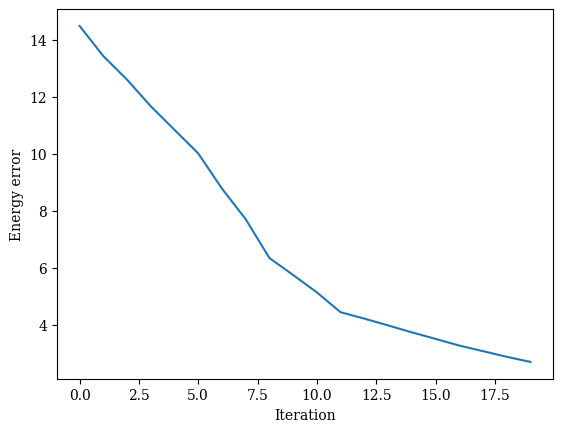

In [7]:
adapt_errors = abs(np.array(adapt_energies) - exact_energy)
fig, ax = plt.subplots()
ax.plot(adapt_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [8]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Get circuit expectation values.

In [9]:
simulator_energies = []
for circuit in circuits:
    sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=adapt_mps_bond)
    estimator = BackendEstimator(backend=sim)
    # The circuit needs to be transpiled to the AerSimulator target
    pass_manager = generate_preset_pass_manager(3, sim)
    isa_circuit = pass_manager.run(circuit)
    isa_circuit = RemoveFinalMeasurements()(isa_circuit)
    pub = (isa_circuit, h_qiskit)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    exact_value = float(pub_result.data.evs)
    simulator_energies.append(exact_value)

In [10]:
simualtor_errors = np.abs(np.array(simulator_energies) - exact_energy)

Text(0, 0.5, 'Energy error')

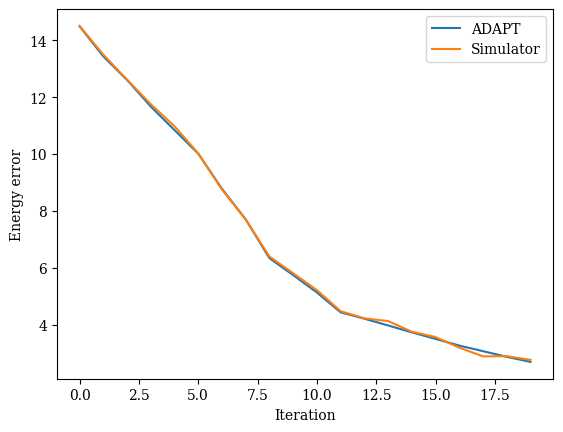

In [11]:
fig, ax = plt.subplots()
ax.plot(adapt_errors, label="ADAPT")
ax.plot(simualtor_errors, label="Simulator")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Carry out SQD.

In [12]:

# spin_a_layout = list(range(0, 12))
# spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
# initial_layout = spin_a_layout + spin_b_layout
initial_layout = range(nq)

# sim = AerSimulator.from_backend(computer, method="matrix_product_state")
sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=4 * adapt_mps_bond)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=sim, initial_layout=initial_layout[:nq]
)


In [13]:
shots_per_circuit = 10_000
num_shots = len(circuits) * shots_per_circuit
sampler = Sampler(sim)

In [14]:

bit_arrays = []
counts_list = []
for i, circuit in enumerate(circuits):
    print(f"On circuit {i}/{len(circuits)}")
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    # job = sim.run(to_run)
    # counts = job.result().data()['counts']
    # bit_array = BitArray.from_counts(counts, num_bits=circuit.num_qubits)
    # counts1 = bit_array.get_counts()
    # num_shots = (i+1) * shots_per_circuit
    job = sampler.run((circuit,), shots=num_shots)
    data = job.result()[0].data
    bit_array = data['meas']
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

On circuit 0/20
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'x': 9, 'cx': 4, 'rx': 2, 'barrier': 2, 'u2': 1, 'rz': 1, 'h': 1})
On circuit 1/20
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'x': 9, 'cx': 8, 'rx': 4, 'h': 3, 'barrier': 3, 'rz': 2, 'u2': 1})
On circuit 2/20
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'cx': 12, 'x': 9, 'rx': 6, 'h': 5, 'barrier': 4, 'rz': 3, 'u2': 1})
On circuit 3/20
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'cx': 16, 'x': 9, 'rx': 8, 'h': 7, 'barrier': 5, 'rz': 4, 'u2': 1})
On circuit 4/20
Gate counts (w/ pre-init passes): OrderedDict({'cx': 20, 'measure': 20, 'rx': 10, 'x': 9, 'h': 9, 'barrier': 6, 'rz': 5, 'u2': 1})
On circuit 5/20
Gate counts (w/ pre-init passes): OrderedDict({'cx': 24, 'measure': 20, 'rx': 12, 'h': 11, 'x': 9, 'barrier': 7, 'rz': 6, 'u2': 1})
On circuit 6/20
Gate counts (w/ pre-init passes): OrderedDict({'cx': 26, 'measure': 20, 'rx': 14, 'h': 13, 'x': 9, 'barrier

In [15]:
energies = []
errors = []

for bit_array in bit_arrays[1:]:
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

Text(0, 0.5, 'Energy error')

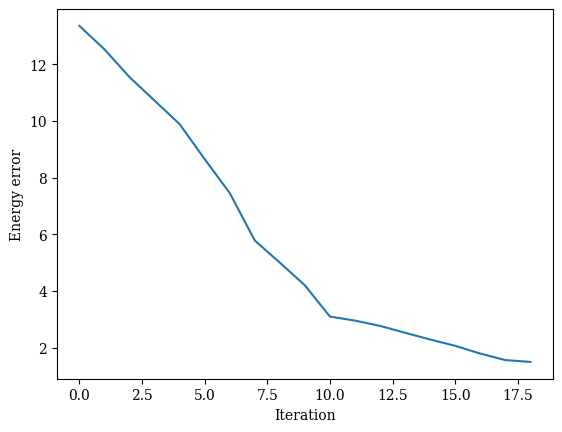

In [16]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [17]:
def randomly_combine_bit_arrays(bit_arrays: List[BitArray], total_shots: int) -> BitArray:
    """Combine several bit arrays by choosing the same number of shots from each of them.
    Choose the shots randomly from each one."""

    shots_per_circuit = [total_shots // len(bit_arrays)] * len(bit_arrays)
    difference = total_shots - sum(shots_per_circuit)
    i = 0
    while i < difference:
        shots_per_circuit[i] += 1
        i += 1
    assert sum(shots_per_circuit) == total_shots

    random_bit_matrices: List[np.ndarray] = []
    num_bits = bit_arrays[0].num_bits
    for i, bit_array in enumerate(bit_arrays):
        assert bit_array.num_shots >= shots_per_circuit[i]
        assert bit_array.num_bits == num_bits
        bit_matrix = bit_array.to_bool_array()
        random_inds = random.sample(list(range(bit_matrix.shape[0])), shots_per_circuit[i])
        random_bit_matrix = bit_matrix[random_inds, :]
        random_bit_matrices.append(random_bit_matrix.copy())
    total_random_bits = np.vstack(random_bit_matrices)
    assert total_random_bits.shape[0] == total_shots
    return BitArray.from_bool_array(total_random_bits)

In [18]:
print(randomly_combine_bit_arrays([bit_arrays[0], bit_arrays[1]], 10))

BitArray(<shape=(), num_shots=10, num_bits=20>)


In [19]:
stacked_energies = []
stacked_errors = []

for i in range(2, len(counts_list) + 1):
    # all_counts = collections.Counter()
    # tuple_of_counts = tuple(counts_list[:i])
    # assert len(tuple_of_counts) == i
    # for counts in tuple_of_counts:
    #     for bitstring, count in counts.items():
    #         all_counts[bitstring] += count

    # bit_array = qiskit.primitives.BitArray.from_counts(all_counts, num_bits=circuits[0].num_qubits)
    bit_array = randomly_combine_bit_arrays(bit_arrays[:i], num_shots)

    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

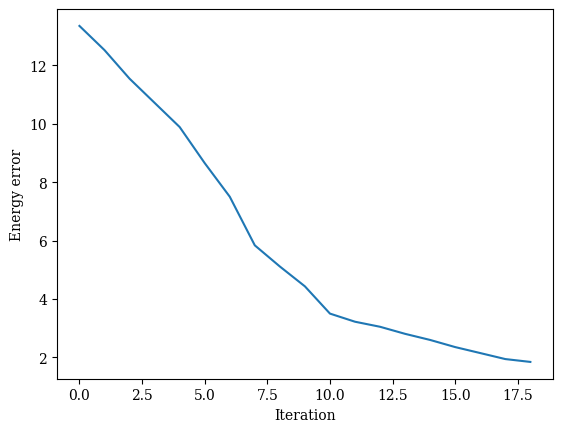

In [20]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

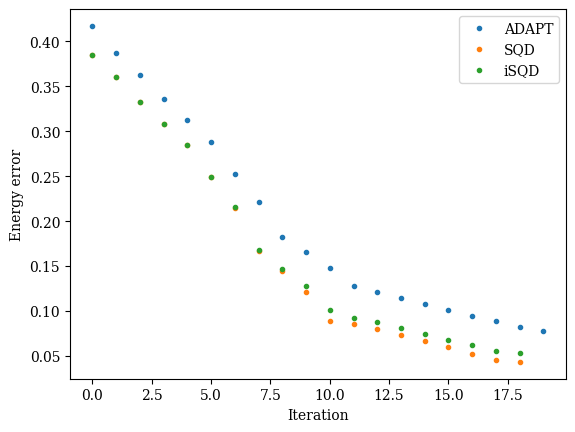

In [21]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="SQD")
ax.plot(stacked_rel_errors, '.', label="iSQD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()

## How many did we keep?

In [22]:
num_kept = []
total_shots = []
for bit_array in bit_arrays:
    bit_matrix = bit_array.to_bool_array()
    original_size = bit_matrix.shape[0]
    bit_matrix = sort_and_remove_duplicates(bit_matrix)
    new_size = bit_matrix.shape[0]
    num_kept.append(new_size)
    total_shots.append(original_size)

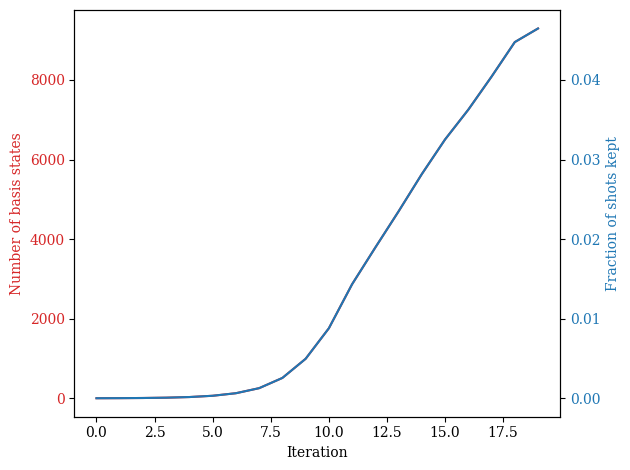

In [23]:
ratio_kept = np.array(num_kept) / np.array(total_shots)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Number of basis states', color=color)
ax1.plot(num_kept, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Fraction of shots kept', color=color)  # we already handled the x-label with ax1
ax2.plot(ratio_kept, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

In [24]:
qasm_strs = []
for circuit in circuits:
    # print(circuit.num_qubits)
    # isa_circuit = pass_manager.run(circuit)
    # print(isa_circuit.num_qubits)
    isa_circuit = circuit
    qasm_str = dumps(isa_circuit)
    qasm_strs.append(qasm_str)

In [25]:
f = h5py.File("data/xxz_output.hdf5", "w")
f.create_dataset("qasm_strs", data=qasm_strs)
f.create_dataset("exact_energy", data=exact_energy)
f.create_dataset("adapt_errors", data=np.array(adapt_errors))
f.create_dataset("sqd_errors", data=np.array(errors))
f.create_dataset("isqd_errors", data=np.array(stacked_errors))
f.close()